# Imports

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import zip_longest
from itertools import combinations
from IPython.display import HTML
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from termcolor import colored
from scipy import spatial


# Load the pretrained word embeddings


In [2]:
embeddings = {}

with open("words/freq_words.txt", 'r') as f:
    for line in f:
        word_info = line.split()
        word = word_info[0]
        embeddings[word] = np.asarray(word_info[1:], "float32")
        
        

We can find the difference between any two words by finding the cosine distance between them. 



In [3]:
def distance(word, reference):
    return spatial.distance.cosine(embeddings[word], embeddings[reference])

def find_closest_embeddings(embed):
    return sorted(embeddings.keys(), key=lambda word: spatial.distance.cosine(embeddings[word], embed))


We can then use this distance to find the closest words to any other word. For instance:

In [4]:
def distance(word, reference):
    return spatial.distance.cosine(embeddings[word], embeddings[reference])

def find_closest_embeddings(embed):
    return sorted(embeddings.keys(), key=lambda word: spatial.distance.cosine(embeddings[word], embed))


We can then use this distance to find the closest words to any other word. For instance:

In [5]:
'king: ' + ', '.join(w for w in find_closest_embeddings(embeddings['king'])[:20])


'king: king, queen, prince, kings, henry, kingdom, reign, throne, george, lord, emperor, charles, son, john, duke, david, solomon, father, ii, edward'

(Side note, you can use this function to do word math, for instance, king - man + woman = queen)

# Set up the board:

Here in the first cell, write the list of words for each team.

In [7]:
our_team = ['bolt', 'kangaroo', 'road', 'cat', 'spirit', 'sling', 'star', 'beach', 'diamond']
their_team = ['cast', 'bee', 'death', 'bunk' ,'mole', 'bowl', 'knife', 'antarctica']
bomb = ['calf']
neutral = ['bikini', 'pine', 'hit' ,'princess', 'stick' ,'soldier']


We then need to set up the words and labels for the model:

In [8]:
labels = ['our_team']*len(our_team) + ['their_team']*len(their_team) + ['bomb'] + ['neutral']*len(neutral)
words = our_team + their_team + bomb + neutral


In [9]:
color_map = {'our_team': 'deeppink', 'their_team':'cornflowerblue', 'bomb':'yellow', 'neutral':'grey'}

Next we will need to put the embeddings for our words into a matrix:

In [10]:
embedding_matrix = [embeddings[key] for key in words]
embedding_matrix = np.array(embedding_matrix)

In [11]:
def word_list_str(group):
    return(', '.join(w for w in group))

print(colored('OUR TEAM: \n' + word_list_str(our_team), 'red'))
print(colored('THEIR TEAM: \n' + word_list_str(their_team), 'blue'))
print(colored('BOMB: \n' + word_list_str(bomb), 'yellow'))
print(colored('NEUTRAL: \n' + word_list_str(neutral), 'grey'))


OUR TEAM: 
bolt, kangaroo, road, cat, spirit, sling, star, beach, diamond
THEIR TEAM: 
cast, bee, death, bunk, mole, bowl, knife, antarctica
BOMB: 
calf
NEUTRAL: 
bikini, pine, hit, princess, stick, soldier



# Reduce dimensions to visualize codenames board
We first want to visualize the words in lower dimensional space so we can decide which of the words we want to clue. This notebook lets you use either t-SNE or PCA, and can reduce to either 2 or 3 dimensions.



In [12]:
def TSNE_fit(embedding_matrix, n_comp = 2):
    N = embedding_matrix.shape[0]
    early_exaggeration = 12
    
    l_rate = N / early_exaggeration / 4
    return TSNE(n_components=n_comp, init='random', perplexity=5, learning_rate = l_rate).fit_transform(embedding_matrix)
    

In [13]:
def PCA_fit(embedding_matrix, n_comp=2):
    return PCA(n_components = n_comp).fit_transform(embedding_matrix)
    

In [14]:
def matrix_to_df(X_embedded, words, labels):
    temp_dict = {}
    temp_list = []
    
    
    for i, row in enumerate(X_embedded):
        temp_dict = {}
        temp_dict['word'] = words[i]
        temp_dict['label'] = labels[i]
        temp_dict['dim1'] = row[0]
        temp_dict['dim2'] = row[1]
        if len(row) == 3:
            temp_dict['dim3'] = row[2]
        temp_list.append(temp_dict)
        
    return pd.DataFrame(temp_list)



In [15]:
def plot_3d(df_reduced, color_map, png = False):
    fig = px.scatter_3d(df_reduced, x = 'dim1', y = 'dim2', z = 'dim3', color = 'label', text = 'word', hover_name = 'word', 
    color_discrete_map= color_map)
    if png == False:
        fig.show()
    elif png == True:
        fig.show("png")
        
        

In [16]:
def plot_2d(df_reduced, color_map, png = False):
    fig = px.scatter(df_reduced, x = 'dim1', y = 'dim2', color = 'label', text = 'word', hover_name = 'word', 
           color_discrete_map= color_map)
    if png == False:
        fig.show()
    elif png == True:
        fig.show("png")

### Reduce to 2D
Let's first reduce to 2 dimensions and plot the results

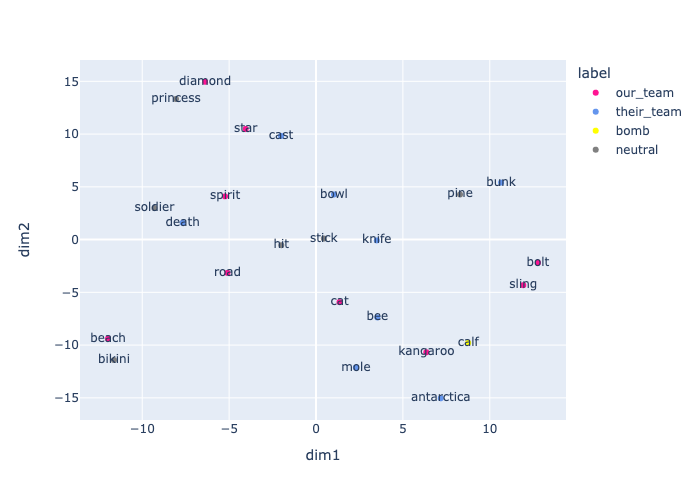

In [26]:
X_embedded = TSNE_fit(embedding_matrix, n_comp = 2)
df_reduced = matrix_to_df(X_embedded, words, labels)
plot_2d(df_reduced, color_map, png = False)


### Reduce to 3D
Plotting in 3D ends up with better results. We can plot and move around to find a good cluster of "our team" words to clue.

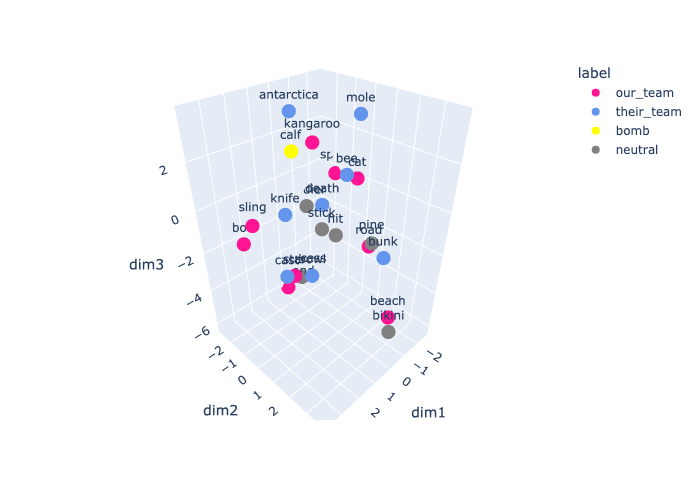

In [27]:
X_embedded = TSNE_fit(embedding_matrix, n_comp = 3)
df_reduced = matrix_to_df(X_embedded, words, labels)
plot_3d(df_reduced, color_map, png = False)

# Clue Generation
Once you decide which words to clue, we can generate a clue! 

Edit the code below with the specific words to clue from "our team"

In [19]:
################### MAKE A CHOICE OF WHICH OF YOUR WORDS TO CLUE
sub_list_our_words = ['sling', 'bolt']
others = their_team + bomb + neutral

In generating a clue, we want to pick a clue that is close to our words and far away from the other words, to maximize the chance that the teammates would pick our words. 

A potential algorithm to solve this is provided by https://jsomers.net/glove-codenames/, adapted here. The idea is that for a given clue, we can calculate the sum of its distances from the other words, and subtract the distance from the good words. We want to maximize this value. 

For the subtraction term, we multiply it by a constant number, to indicate that closeness to our words is more important than distance from other words. 


In [20]:
multiplier = 4.0

def goodness(word, answers, bad):
    if word in answers + bad: return -999
    return sum([distance(word, b) for b in bad]) - multiplier * sum([distance(word, a) for a in answers])

def minimax(word, answers, bad):
    if word in answers + bad: return -999
    return min([distance(word, b) for b in bad]) - max([distance(word, a) for a in answers])

def candidates(answers, bad, size=100):
    best = sorted(embeddings.keys(), key=lambda w: -1 * goodness(w, answers, bad))
    res = [(str(i + 1), "{0:.2f}".format(minimax(w, answers, bad)), w) for i, w in enumerate(sorted(best[:250], key=lambda w: -1 * minimax(w, answers, bad))[:size])]
    return [(". ".join([c[0], c[2]]) + " (" + c[1] + ")") for c in res]

In [21]:
candidate_clue_words = candidates(sub_list_our_words, others, size=100)


In [22]:
candidate_clue_words[:20]

['1. lug (0.13)',
 '2. recoil (0.13)',
 '3. harness (0.12)',
 '4. coupler (0.12)',
 '5. handlebar (0.11)',
 '6. adjuster (0.11)',
 '7. tether (0.10)',
 '8. latch (0.10)',
 '9. fastener (0.10)',
 '10. absorber (0.10)',
 '11. attaches (0.10)',
 '12. fastening (0.10)',
 '13. mounts (0.09)',
 '14. lifter (0.09)',
 '15. winch (0.09)',
 '16. slings (0.09)',
 '17. m16 (0.09)',
 '18. swivel (0.09)',
 '19. detach (0.09)',
 '20. 20mm (0.09)']

# Plot the clue words
We can then plot the clues in the same space as before.

In [23]:
potential_clues_list = candidate_clue_words[:10]

In [24]:
clue_words = [potential_clues_list[i].split(' ')[1] for i, r in enumerate(potential_clues_list)]
clue_matrix = [embeddings[word] for word in clue_words]
embedding_matrix_with_clue = np.vstack((embedding_matrix, clue_matrix))
words_b = words + clue_words

labels_b = labels + ['clue']* len(clue_words)
color_map['clue'] = 'lightgreen'

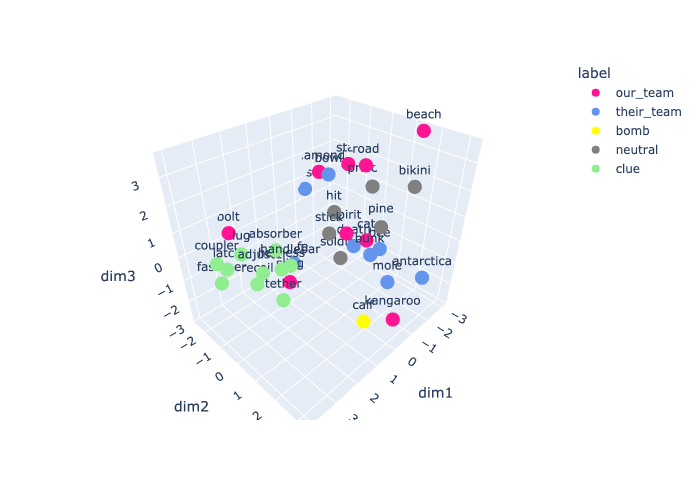

In [28]:
X_embedded = PCA_fit(embedding_matrix_with_clue, n_comp = 3)
df_reduced = matrix_to_df(X_embedded, words_b, labels_b)
plot_3d(df_reduced, color_map, png = False)